# FLEX approximation
## Theory of FLEX in the paramagnetic state

The Fluctuation Exchange (FLEX) approximation is a perturbative diagrammatic method that was first introduced by Bickers et al. {cite:p}`Bickers89a,Bickers89b`. It can be derived from a Luttinger-Ward functional {cite:p}`Luttinger60` containing an infinite series of closed bubble and ladder diagrams. Physically, this means that in FLEX the exchange of spin- and charge fluctuatiosn is treated self-consistently. As such, it is suitable for studying systems with strong spin fluctuations, e.g., in Fermi liquids or near quantum critical points. Here, we want to give a code example of the single-orbital limit of FLEX with a local Hubbard interaction $U$ to illustrate the practical implementation of the Sparse-ir package for diagrammatic methods.

For the implementation of a multi-orbital code, please have a look at {cite:p}`Witt21` and [FLEX_IR package](https://github.com/nikwitt/FLEX_IR).

#### Set of FLEX equations
We review the set of equations that need to be solved self-consistently in the FLEX approximation. The goal is to solve the Dyson equation

$$
\begin{align}
G(i\omega_n,\boldsymbol{k}) &= [G_0^{-1}(i\omega_n,\boldsymbol{k}) - \Sigma(i\omega_n,\boldsymbol{k})]^{-1} \\
& = [i\omega_n - (\varepsilon_{\boldsymbol{k}}-\mu)) - \Sigma(i\omega_n,\boldsymbol{k})]^{-1}.
\end{align}
$$

for the interacting Green function $G$ from the non-interacting Greenfunction $G_0(i\omega_n,\boldsymbol{k}) = [i\omega_n - (\varepsilon_{\boldsymbol{k}}-\mu]^{-1}$ with single-particle dispersion $\varepsilon_{\boldsymbol{k}}$ and chemical potential $\mu$ as well as self-energy $\Sigma$ as a function of Matsubara frequencies $i\omega_n=(2n+1)\pi T$ and momentum $\boldsymbol{k}$. Using the Green function, we calculate the irreducible susceptibility ("bubble diagram") as

$$ \chi_0(i\nu_m, \boldsymbol{q}) = - \frac{T}{N_{\boldsymbol{k}}} \sum_{n,\boldsymbol{k}} G(i\omega_n + i\nu_m, \boldsymbol{k} + \boldsymbol{q})G(i\omega_n, \boldsymbol{k})\;.$$

$N_{\boldsymbol{k}}$ denotes the number of $\boldsymbol{k}$-points. This equation is convolution typical in diagrammatic methods. It can be easily evaluated by Fourier transforming to imaginary time and real space, resulting in a simple multiplication

$$ \chi_0(\tau, \boldsymbol{r}) = - G(\tau, \boldsymbol{r})G(-\tau,-\boldsymbol{r}) = G(\tau, \boldsymbol{r})G(\beta-\tau,\boldsymbol{r})\;.$$

In our practical implementation, we will perform this step using the sparse-ir package. The infinite sum of bubble and ladder diagrams can be resummed to yeald a Berk-Shrieffer type interaction []

$$ V(i\nu_m, \boldsymbol{q}) = \frac{3}{2} U^2 \chi_{\mathrm{s}}(i\nu_m, \boldsymbol{q}) + \frac{1}{2} U^2 \chi_{\mathrm{c}}(i\nu_m, \boldsymbol{q}) - U^2 \chi_0(i\nu_m, \boldsymbol{q}) + U $$

with spin and charge susceptibility like in the Random-Phase-Approximation (RPA) 

$$ \chi_{\mathrm{s}}(i\nu_m, \boldsymbol{q}) = \frac{\chi_0(i\nu_m, \boldsymbol{q})}{1-U\chi_0(i\nu_m, \boldsymbol{q})} \quad , \quad \chi_{\mathrm{c}}(i\nu_m, \boldsymbol{q}) = \frac{\chi_0(i\nu_m, \boldsymbol{q})}{1+U\chi_0(i\nu_m, \boldsymbol{q})}\;. $$

The self-energy can be calculated from the convolution

$$ \Sigma(i\omega_n, \boldsymbol{k}) = \frac{T}{N_{\boldsymbol{k}}} \sum_{m,\boldsymbol{q}} V(i\nu_m, \boldsymbol{q}) G(i\omega_n - i\nu_m, \boldsymbol{k} - \boldsymbol{q}) $$

which Fourier transformed to real space takes the form

$$ \Sigma(\tau, \boldsymbol{r}) = V(\tau, \boldsymbol{r}) G(\tau, \boldsymbol{r})\;. $$

Thus, we have the set of self-consistent equations complete. In every iteration, the chemical potential $\mu$ needs to be adjusted to keep the electron density $n$ fixed. It can be calculated via solving

$$ n = 2n_{\sigma} = 2 - \frac{2}{N_{\boldsymbol{k}}} \sum_{\boldsymbol{k}} G(\tau=0^+, \boldsymbol{k}) $$

with a factor 2 from spin degeneracy and $0^+ = \lim_{\eta\to 0+} \eta$ by using some root finding algorithm like bisection method or Brent's method.

#### Practical implementation
When implementing the fully self-consistent FLEX loop, a few points need to be treated carefully which we discuss in the following.

* The constant Hartree term $V_{\mathrm{H}} = U$ in the interaction $V$ and respective self-energy term $\Sigma_H = U\frac{n}{2}$ can be absorbed into the definition of the chemical potential $\mu$.
* We include a mixing $p<1$ in each iteration step, such that the Green function of step $n+1$ is partially constructed from the old and new Green function: $$G^{n+1} = p\,G^{n+1} + (1-p)\,G^{n}$$ This smoothes down too strong oscillations of the solution.
* A bottleneck of the FLEX approximation is the case of too strong interactions. The solution turns numerically unstable, if the denominator of $\chi_{\mathrm{s}}$ approaches zero, i.e., $U\max\!\{\chi_{0}\} \to 1$. Typically, this can be solved by starting with a smaller $U$ value and slowly turning it up. We call this "$U$ renormalization".

## Code implementation
We are implementing the FLEX method for the simple case of a square lattice model with dispersion $\varepsilon_{\boldsymbol{k}} = -2t\,[\cos(k_x) + \cos(k_y)]$ with nearest-neighbor hopping $t$ which sets the energy scale of our system (bandwith $W = 8t$). First, we load all necessary basic modules that we are going to need in implementing FLEX and visualizing results:

In [1]:
import numpy as np
import scipy as sc
import scipy.optimize
import sparse_ir
%matplotlib inline
import matplotlib.pyplot as plt

#### Parameter setting

In [2]:
### System parameters
t    = 1      # hopping amplitude
W    = 8*t    # bandwith
wmax = 10     # set wmax >= W

T    = 0.1   # temperature
beta = 1/T    # inverse temperature
n    = 0.85   # electron filling, here per spin per lattice site (n=1: half filling)
U    = 4      # Hubbard interaction

### Numerical parameters
nk1, nk2  = 24, 24    # number of k_points along one repiprocal crystal lattice direction k1 = kx, k2 = ky
nk        = nk1*nk2
IR_tol    = 1e-10     # accuary for l-cutoff of IR basis functions
sfc_tol   = 1e-4      # accuracy for self-consistent iteration
it_max    = 30        # maximal number of iterations in self-consistent cycle
mix       = 0.2       # mixing parameter for new 
U_it_max  = 50        # maximal number of iteration steps in U renormalization loop

#### Generating meshes
We need to generate a $\boldsymbol{k}$-mesh as well as set up the IR basis functions on a sparse $\tau$ and $i\omega_n$ grid. Then we can calculate the dispersion on this mesh.

In [3]:
### Generating k-mesh and dispersion
k1, k2 = np.meshgrid(np.arange(nk1)/nk1, np.arange(nk2)/nk2)
ek     = -2*t*( np.cos(2*np.pi*k1) + np.cos(2*np.pi*k2) ).reshape(nk)

#### Initiate fermionic and bosonic IR basis objects
basis_f = sparse_ir.FiniteTempBasis("F", beta, wmax, eps=IR_tol)
basis_b = sparse_ir.FiniteTempBasis("B", beta, wmax, eps=IR_tol)


# generate instances for sparse sampling grids (we use the default mesh here)
tauSparse_f = sparse_ir.TauSampling(basis_f)
iwnSparse_f = sparse_ir.MatsubaraSampling(basis_f)

tauSparse_b = sparse_ir.TauSampling(basis_b)
iwnSparse_b = sparse_ir.MatsubaraSampling(basis_b)

# lowest Matsubara frequency index
iw0_f = np.where(iwnSparse_f.wn == 1)[0][0]
iw0_b = np.where(iwnSparse_b.wn == 0)[0][0]


### Generate a frequency-momentum grid for iwn and ek (in preparation for calculating the Green function)
# frequency mesh (for Green function)
iwn_f = 1j * iwnSparse_f.wn * np.pi * T
iwn_f_ = np.tensordot(iwn_f, np.ones(nk), axes=0)

# ek mesh
ek_ = np.tensordot(np.ones(len(iwn_f)), ek, axes=0)

#### FLEX calculation steps
We write functions to calculate each step of the FLEX loop individually (so that we only need to link them later).

In [4]:
### Calculate Green function G(iw,k)
def gkio_calc(iwn, ek, mu, sigma):
    ''' Expects iwn, ek to be of same shape'''
    gkio = (iwn - (ek - mu) - sigma )**(-1)
    return gkio

### Calculate real space Green function G(tau,r) [for calculating chi0 and sigma]
def grit_calc(gkio):
    grit = gkio.reshape(len(iwnSparse_f.wn), nk1, nk2)
    
    # Fourier transform to real space
    grit = np.fft.fftn(grit,axes=(1,2))
    grit = grit.reshape(len(iwnSparse_f.wn), nk)
    
    # Fourier transform to imaginary time via IR basis fit for G_l
    # both G(tau_F) and G(tau_B) are neeced for calculating sigma and chi0, respectively
    grit_l = iwnSparse_f.fit(grit)
    grit_f = tauSparse_f.evaluate(grit_l)
    grit_b = tauSparse_b.evaluate(grit_l)
    
    return grit_f, grit_b

### Calculate irreducible susciptibility chi0(iv,q)
def ckio_calc(grit_b):
    ckio = grit_b * grit_b[::-1, :]
    
    # Fourier transform of momentum
    ckio = ckio.reshape(len(tauSparse_b.tau), nk1, nk2)
    ckio = np.fft.ifftn(ckio,axes=(1,2))/nk
    ckio = ckio.reshape(len(tauSparse_b.tau), nk)
    
    # Fourier transform to Matsubara frequency via IR basis fit for chi0_l
    ckio_l = tauSparse_b.fit(ckio)
    ckio = iwnSparse_b.evaluate(ckio_l)
    
    return ckio

### Calculate interaction V(tau,r) from RPA-like spin and charge susceptibility for calculating sigma
def V_calc(ckio, U):
    # spin and charge susceptibility
    chi_spin   = ckio / (1 - U*ckio)
    chi_charge = ckio / (1 + U*ckio)
    
    V = 3/2*U**2 * chi_spin + 1/2*U**2 * chi_charge - U**2 * ckio
    # Constant Hartree Term V ~ U needs to be treated extra, since they cannot be modeled by the IR basis.
    # In the single-band case, the Hartree term can be absorbed into the chemical potential.
    
    # Fourier transform to real space
    V = V.reshape(len(iwnSparse_b.wn),nk1,nk2)
    V = np.fft.fftn(V,axes=(1,2))
    V = V.reshape(len(iwnSparse_b.wn), nk)
    
    # Fourier transform to imaginary time via IR basis fit for V_l on tau_F!
    V_l = iwnSparse_b.fit(V)
    V = tauSparse_f.evaluate(V_l)
    
    return V

### Calculate self-energy Sigma(iwn,k)
def sigma_calc(grit_f, V):
    sigma = V * grit_f
    
    # Fourier transform to momentum space
    sigma = sigma.reshape(len(tauSparse_f.tau),nk1,nk2)
    sigma = np.fft.ifftn(sigma,axes=(1,2))/nk
    sigma = sigma.reshape(len(tauSparse_f.tau), nk)
    
    # Fourier transform to Matsubara frequency via IR basis fit for sigma_l
    sigma_l = tauSparse_f.fit(sigma)
    sigma   = iwnSparse_f.evaluate(sigma_l)
    
    return sigma

##### Setting the chemical potential

In [5]:
### Calculate chemical potential mu from Green function    
def calc_electron_density(iwn, ek, mu, sigma):
    gkio = gkio_calc(iwn, ek, mu, sigma)
    gio  = np.sum(gkio,axis=1)/nk
    g_l  = iwnSparse_f.fit(gio)
    g_tau0 = basis_f.u(0)@g_l
    
    n  = 1 + np.real(g_tau0)
    n  = 2*n #for spin
    return n

# Find chemical potential for a given filling n0 via brentq root finding algorithm
def mu_calc(n0, iwn, ek, sigma):
    n = calc_electron_density
    f = lambda mu : n(iwn, ek, mu, sigma) - n0

    mu = sc.optimize.brentq(f, np.amax(ek)*3, np.amin(ek)*3)
    return mu

### Execute FLEX loop

In [6]:
# Initialize calculation
sigma = 0
mu    = 0

# Start 0th round - corresponds to RPA
mu   = mu_calc(n, iwn_f_, ek_, sigma)
gkio = gkio_calc(iwn_f_, ek_, mu, sigma)
grit_f, grit_b = grit_calc(gkio)
ckio  = ckio_calc(grit_b)

# Check whether U < U_crit! Otherwise, U needs to be renormalized.
if np.amax(np.abs(ckio))*U >= 1:
    print('WARNING: U is too large and the spin susceptibility denominator will diverge/turn unphysical!')
    print('Initiate renormalization loop.')
    
    # Save old U for later
    U_old = U
    # Renormalization loop may run infinitely! Insert break condition after U_it_max steps
    U_it = 0
    
    while U_old*np.amax(np.abs(ckio)) >= 1:
        U_it += 1
        
        # remormalize U such that U*chi0 < 1
        U = U / (np.amax(np.abs(ckio))*U + 0.01)
        
        # perform one shot FLEX loop
        sigma_old = sigma
        gkio_old  = gkio
        V     = V_calc(ckio, U)
        sigma = sigma_calc(grit_f, V)
    
        mu   = mu_calc(n, iwn_f_, ek_, sigma)
        gkio = gkio_calc(iwn_f_, ek_, mu, sigma)
        gkio = mix*gkio + (1-mix)*gkio_old
    
        grit_f, grit_b = grit_calc(gkio)
        ckio  = ckio_calc(grit_b)
        
        # reset U
        U = U_old
        
        # break condition for too many steps
        if U_it == U_it_max:
            print('U renormalization reached breaking point')
            break

# Do self-consistent iteration until convergence
for it in range(it_max):
    sigma_old = sigma
    gkio_old  = gkio
    V     = V_calc(ckio, U)
    sigma = sigma_calc(grit_f, V)
    
    mu   = mu_calc(n, iwn_f_, ek_, sigma)
    gkio = gkio_calc(iwn_f_, ek_, mu, sigma)
    gkio = mix*gkio + (1-mix)*gkio_old
    
    grit_f, grit_b = grit_calc(gkio)
    ckio  = ckio_calc(grit_b)
    
    # Check whether solution is converged.
    sfc_check = np.sum(abs(sigma-sigma_old))/np.sum(abs(sigma))
    print(it, sfc_check)
    if sfc_check < sfc_tol:
        break

Initiate renormalization loop.

0

0.08757050701882461

1

0.14458517806196805

2

0.022496516962789898

3

0.01182607502223439

4

0.007576749380836261

5

0.005298268436796728

6

0.003862726088047783

7

0.002873781663750474

8

0.0021584597623225295

9

0.0016284507934084416

10

0.0012315292636754921

11

0.0009331890338140588

12

0.0007086077737272701

13

0.0005394112523598685

14

0.0004118689361408585

15

0.00031563153401797554

16

0.00024290673624857852

17

0.00018780238679926622

18

0.00014592983406539405

19

0.00011401152358553455

20

8.956735422398304e-05

#### Visualize results

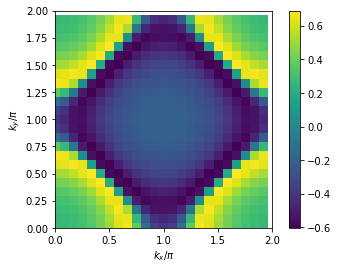

In [7]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. green function
plt.pcolormesh(2*k1.reshape(nk1,nk2), 2*k2.reshape(nk1,nk2), np.real(gkio[iw0_f].reshape(nk1,nk2)), shading='auto')
ax = plt.gca()
ax.set_xlabel('$k_x/\pi$')
ax.set_xlim([0,2])
ax.set_ylabel('$k_y/\pi$')
ax.set_ylim([0,2])
ax.set_aspect('equal')
plt.colorbar()
plt.show()

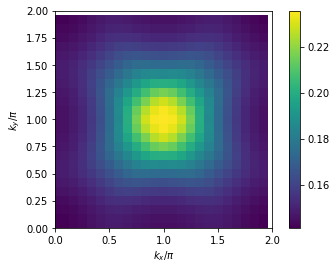

In [8]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. chi0
plt.pcolormesh(2*k1.reshape(nk1,nk2), 2*k2.reshape(nk1,nk2), np.real(ckio[iw0_b].reshape(nk1,nk2)), shading='auto')
ax = plt.gca()
ax.set_xlabel('$k_x/\pi$')
ax.set_xlim([0,2])
ax.set_ylabel('$k_y/\pi$')
ax.set_ylim([0,2])
ax.set_aspect('equal')
plt.colorbar()
plt.show()

## Linearized Eliashberg equation
One example for which FLEX can be used, is the description of superconductivity arising from spin-fluctuation-mediated pairing. While it is possible to perform FLEX calculations in the symmetry-broken state (Nambu phase), we will here focus on determining the superconducting critical temperature $T_{\mathrm{c}}$ by solving the linearized Eliashberg equation

$$
\begin{align}
\Delta^{(\xi)}(i\omega_n, \boldsymbol{k}) &= \frac{T}{N_{\boldsymbol{k}}} \sum_{m,\boldsymbol{q}} V^{(\xi)}(i\nu_m, \boldsymbol{q})F^{(\xi)}(i\omega_n - i\nu_m, \boldsymbol{k}-\boldsymbol{q}) \\
 &= -\frac{T}{N_{\boldsymbol{k}}} \sum_{m,\boldsymbol{q}} V^{(\xi)}(i\nu_m, \boldsymbol{q}) |G(i\omega_n - i\nu_m, \boldsymbol{k} - \boldsymbol{q})|^2 \Delta^{(\xi)}(i\omega_n - i\nu_m, \boldsymbol{k}-\boldsymbol{q})
\end{align}
 $$

for the gap function $\Delta$ ('order parameter') in either the spin singlet ($\xi=\mathrm{S}$) or spin triplet ($\xi=\mathrm{T}$) pairing channel. $F^{(\xi)} = -|G|^2\Delta^{(\xi)}$ is the anomalous Green function. In each case, the interaction is given by

$$
\begin{align}
    V^{(\xi=\mathrm{S})}(i\nu_m, \boldsymbol{q}) &= \frac{3}{2}U^2\chi_{\mathrm{s}}(i\nu_m, \boldsymbol{q}) - \frac{1}{2}U^2\chi_{\mathrm{c}}(i\nu_m, \boldsymbol{q}) + U,\\
    V^{(\xi=\mathrm{T})}(i\nu_m, \boldsymbol{q}) &= -\frac{1}{2}U^2\chi_{\mathrm{s}}(i\nu_m, \boldsymbol{q}) - \frac{1}{2}U^2\chi_{\mathrm{c}}(i\nu_m, \boldsymbol{q}).
\end{align}
$$

The gap equation is effectively an eigenvalue problem with $\Delta$ being the eigenvector and $\mathcal{K}\sim V |G|^2$ the matrix. Since we are only interested in the phase transition of the dominant symmetry pairing channel, we can solve for the largest eigenvalue $\lambda$ via the power method.

In this tutorial, we want to calculate the superconducting transition line for the dominant singlet $d\equiv d_{x^2-y^2}$-wave symmetric gap function. We initialize the calculation with a generic function of this symmetry (constant in frequency space):

$$
\Delta_{d}^0(\boldsymbol{k}) = \cos(k_x) - \cos(k_y)
$$

### Code implementation

In [9]:
### Set up interaction in real space and imaginary time
def V_singlet_calc(ckio, U):
    chi_spin   = ckio / (1 - U*ckio)
    chi_charge = ckio / (1 + U*ckio)
    
    V = 3/2*U**2 * chi_spin - 1/2*U**2 * chi_charge
    # Constant Hartree Term V ~ U needs to be treated extra, since they cannot be modeled by the IR basis.
    # In the special case of d-wave symmetry, it can be neglected.
    
    # Fourier transform to real space
    V = V.reshape(len(iwnSparse_b.wn),nk1,nk2)
    V = np.fft.fftn(V,axes=(1,2))
    V = V.reshape(len(iwnSparse_b.wn), nk)
    
    # Fourier transform to imaginary time via IR basis fit for V_l on tau_F!
    V_l = iwnSparse_b.fit(V)
    V = tauSparse_f.evaluate(V_l)
    return V

### Calc (linearized) anomalous Green function F = |G|^2 * delta for evaluating the gap equation
def F_calc(gkio, delta):
    F = - gkio*np.conj(gkio)*delta
    F = F.reshape(len(iwnSparse_f.wn), nk1, nk2)
    
    # Fourier transform to real space
    F = np.fft.fftn(F,axes=(1,2))
    F = F.reshape(len(iwnSparse_f.wn), nk)
    
    # Fourier transform to imaginary time via IR basis fit for G_l
    # both G(tau_F) and G(tau_B) are neeced for calculating sigma and chi0, respectively
    F_l = iwnSparse_f.fit(F)
    F = tauSparse_f.evaluate(F_l)
    return F

In [10]:
### Start power method loop
# Set initial gap function
delta_k = np.cos(2*np.pi*k1) - np.cos(2*np.pi*k2)
delta_k = delta_k.reshape(nk)
delta = np.tensordot(np.ones(len(iwn_f)), delta_k, axes=0)
delta = delta / np.linalg.norm(delta) # normalize initial guess

# Start self-consistency loop
V_singlet = V_singlet_calc(ckio, U)

lam = 0
for it in range(it_max):
    delta_old = delta
    lam_old = lam
    
    F = F_calc(gkio, delta)
    delta = V_singlet * F
    
    # Fourier transform to momentum space
    delta = delta.reshape(len(tauSparse_f.tau),nk1,nk2)
    delta = np.fft.ifftn(delta,axes=(1,2))/nk
    delta = delta.reshape(len(tauSparse_f.tau), nk)
    
    # Fourier transform to Matsubara frequency via IR basis fit for sigma_l
    delta_l = tauSparse_f.fit(delta)
    delta   = iwnSparse_f.evaluate(delta_l)
    
    # Calcualte eigenvalue
    lam = np.real( np.sum(np.conj(delta)*delta_old) )
    delta = delta / np.linalg.norm(delta)
    
    print(it, lam, abs(lam-lam_old))
    if abs(lam-lam_old) < sfc_tol:
        break

print("The superconducting eigenvalue is lambda_d = {}".format(lam))

0

0.10885846909777742

0.10885846909777742

1

0.40584449241290865

0.29698602331513124

2

0.4494182491085299

0.043573756695621246

3

0.45617269033927926

0.006754441230749364

4

0.4577756243092219

0.0016029339699426548

5

0.4581551402137718

0.0003795159045498764

6

0.45825720409295384

0.00010206387918204607

7

0.45828371844136684

2.6514348412998157e-05

The superconducting eigenvalue is lambda_d = 0.45828371844136684

#### Visualize results

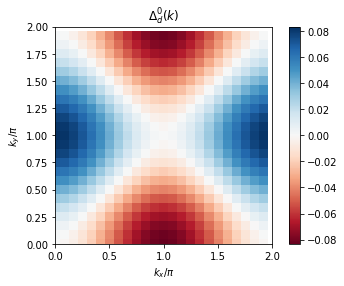

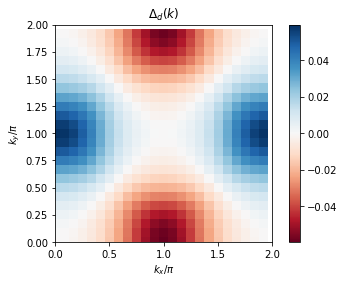

In [11]:
# plot 2D k-dependence of lowest Matsubara frequency of the gap vs. initial guess
plt.figure()
plt.pcolormesh(2*k1.reshape(nk1,nk2), 2*k2.reshape(nk1,nk2), np.real(delta_k.reshape(nk1,nk2)) / np.linalg.norm(delta_k), cmap='RdBu', shading='auto')
ax = plt.gca()
ax.set_xlabel('$k_x/\pi$')
ax.set_xlim([0,2])
ax.set_ylabel('$k_y/\pi$')
ax.set_ylim([0,2])
ax.set_aspect('equal')
ax.set_title('$\\Delta^0_d(k)$')
plt.colorbar()

plt.figure()
plt.pcolormesh(2*k1.reshape(nk1,nk2), 2*k2.reshape(nk1,nk2), np.real(delta[iw0_f].reshape(nk1,nk2)), cmap='RdBu', shading='auto')
ax = plt.gca()
ax.set_xlabel('$k_x/\pi$')
ax.set_xlim([0,2])
ax.set_ylabel('$k_y/\pi$')
ax.set_ylim([0,2])
ax.set_aspect('equal')
ax.set_title('$\\Delta_d(k)$')
plt.colorbar()
plt.show()

## Example: $d$-wave superconductivity in the square-lattice Hubbard model
In this section, we will reproduce Figs. 3(b) and 4 of {cite:p}`Arita00` or respective Fig. 2(a) of {cite:p}`Witt21` using the SparseIR FLEX code developed above. It shows (i) the momemtum dependence of the static spin susceptibility and (ii) the temperature dependence of the superconducting eigenvalue $\lambda_d$ (as calculated above) and the inverse maximal spin susceptibility $1/\chi_{\mathrm{s,max}}$, which indicates tendency towards magnetic ordering.

In order to perform calcualtions for different $T$, we will initiate the IR basis with a $\Lambda = \beta_{\mathrm{max}}\omega_{\mathrm{max}}$ that is sufficient for the lowest temperature $T_{\mathrm{min}} = 1/\beta_{\mathrm{max}}$ we plan to do calculations for. Since $T$ changes, we have to use the dimensionless basis and when Fourier transforming account for a factor $\sqrt{2}T$ from prefactors $U_l(\tau) = \sqrt{2T}u_l(x)$ and $U_l(i\omega_n) = \sqrt{1/T}u_{ln}$ accordingly. We start from high $T$ and lower its value. Each new $T$ calculation is initiated using the previously converged solution, since it does not change drastically.

You can simply execute the following code block which will generate a Figure like in the references above.

Initialization...


Entering FLEX calculation loop:

Now: T = 0.08

Initiate renormalization loop.

The superconducting eigenvalue is lambda_d = 0.5344740819597865

Now: T = 0.07

The superconducting eigenvalue is lambda_d = 0.5781805472821936

Now: T = 0.06

The superconducting eigenvalue is lambda_d = 0.633023261101833

Now: T = 0.05

The superconducting eigenvalue is lambda_d = 0.6987759570720455

Now: T = 0.04

The superconducting eigenvalue is lambda_d = 0.7805599817812404

Now: T = 0.03

The superconducting eigenvalue is lambda_d = 0.8864247039081055

Now: T = 0.025

The superconducting eigenvalue is lambda_d = 0.9525764224346484


Plotting the results...


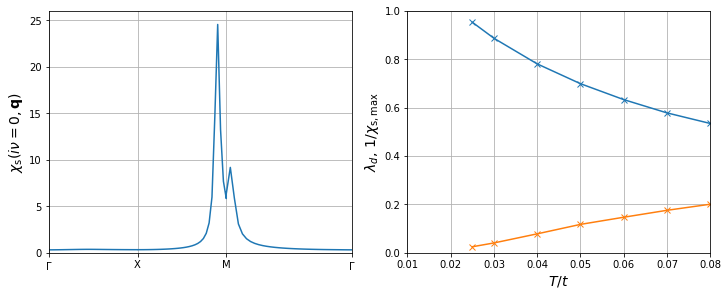

In [12]:
#%%%%%%%%%%%%%%% Parameter settings
print('Initialization...')
# System parameters
t    = 1      # hopping amplitude
n    = 0.85   # electron filling, here per spin per lattice site (n=1: half filling)
U    = 4      # Hubbard interaction

W    = 8*t    # bandwith
wmax = 10     # set wmax >= W
T_values = np.array([0.08,0.07,0.06,0.05,0.04,0.03,0.025])   # temperature

# empty arrays for results later
lam_T     = np.empty((len(T_values)))
chiSmax_T = np.empty((len(T_values)))

# Numerical parameters
nk1, nk2  = 64, 64    # k-mesh sufficiently dense!
nk        = nk1*nk2
IR_Lambda = 10**3     # dimensionless IR parameter >= w_max * beta_min = 400
IR_tol    = 1e-8      # accuary for l-cutoff of IR basis functions
sfc_tol   = 1e-4      # accuracy for self-consistent iteration
it_max    = 30        # maximal number of iterations in self-consistent cycle
mix       = 0.2       # mixing parameter for new 
U_it_max  = 50        # maximal number of iteration steps in U renormalization loop


#%%%%%%%%%%%%%%%% Mesh generation and IR basis initialization
# fermionic and bosonic IR basis objects (dimensionless)
basis_f = sparse_ir.IRBasis(statistics='F', lambda_=IR_Lambda, eps=IR_tol)
basis_b = sparse_ir.IRBasis(statistics='B', lambda_=IR_Lambda, eps=IR_tol)

# sparse sampling grids (we use the default mesh here)
tauSparse_f = sparse_ir.TauSampling(basis_f)
iwnSparse_f = sparse_ir.MatsubaraSampling(basis_f)

tauSparse_b = sparse_ir.TauSampling(basis_b)
iwnSparse_b = sparse_ir.MatsubaraSampling(basis_b)

# lowest Matsubara frequency index
iw0_f = np.where(iwnSparse_f.wn == 1)[0][0]
iw0_b = np.where(iwnSparse_b.wn == 0)[0][0]

# k-mesh and dispersion
k1, k2 = np.meshgrid(np.arange(nk1)/nk1, np.arange(nk2)/nk2)
ek  = -2*t*( np.cos(2*np.pi*k1) + np.cos(2*np.pi*k2) ).reshape(nk)
ek_ = np.tensordot(np.ones(len(iwnSparse_f.wn)), ek, axes=0)


#%%%%%%%%%%%%%%%% Function definition for calculation
### Necessary to reiterate here, so that parameters from above are applied
### Calculate Green function G(iw,k)
def gkio_calc(iwn, ek, mu, sigma):
    ''' Expects iwn, ek to be of same shape'''
    gkio = (iwn - (ek - mu) - sigma )**(-1)
    return gkio

### Calculate real space Green function G(tau,r) [for calculating chi0 and sigma]
def grit_calc(gkio, T):
    grit = gkio.reshape(len(iwn_f), nk1, nk2)
    
    # Fourier transform to real space
    grit = np.fft.fftn(grit,axes=(1,2))
    grit = grit.reshape(len(iwnSparse_f.wn), nk)
    
    # Fourier transform to imaginary time via IR basis fit for G_l
    # both G(tau_F) and G(tau_B) are neeced for calculating sigma and chi0, respectively
    grit_l = iwnSparse_f.fit(grit)
    grit_f = tauSparse_f.evaluate(grit_l) * np.sqrt(2)*T
    grit_b = tauSparse_b.evaluate(grit_l) * np.sqrt(2)*T
    
    return grit_f, grit_b

### Calculate irreducible susciptibility chi0(iv,q)
def ckio_calc(grit_b, T):
    ckio = grit_b * grit_b[::-1, :]
    
    # Fourier transform of momentum
    ckio = ckio.reshape(len(tauSparse_b.tau), nk1, nk2)
    ckio = np.fft.ifftn(ckio,axes=(1,2))/nk
    ckio = ckio.reshape(len(tauSparse_b.tau), nk)
    
    # Fourier transform to Matsubara frequency via IR basis fit for chi0_l
    ckio_l = tauSparse_b.fit(ckio)
    ckio = iwnSparse_b.evaluate(ckio_l) * 1/(np.sqrt(2)*T)
    
    return ckio

### Calculate interaction V(tau,r) from RPA-like spin and charge susceptibility for calculating sigma
def V_calc(ckio, U, T):
    # spin and charge susceptibility
    chi_spin   = ckio / (1 - U*ckio)
    chi_charge = ckio / (1 + U*ckio)
    
    V = 3/2*U**2 * chi_spin + 1/2*U**2 * chi_charge - U**2 * ckio
    # Constant Hartree Term V ~ U needs to be treated extra, since they cannot be modeled by the IR basis.
    # In the single-band case, the Hartree term can be absorbed into the chemical potential.
    
    # Fourier transform to real space
    V = V.reshape(len(iwnSparse_b.wn),nk1,nk2)
    V = np.fft.fftn(V,axes=(1,2))
    V = V.reshape(len(iwnSparse_b.wn), nk)
    
    # Fourier transform to imaginary time via IR basis fit for V_l on tau_F!
    V_l = iwnSparse_b.fit(V)
    V = tauSparse_f.evaluate(V_l) * np.sqrt(2)*T
    
    return V

### Calculate self-energy Sigma(iwn,k)
def sigma_calc(grit_f, V, T):
    sigma = V * grit_f
    
    # Fourier transform to momentum space
    sigma = sigma.reshape(len(tauSparse_f.tau),nk1,nk2)
    sigma = np.fft.ifftn(sigma,axes=(1,2))/nk
    sigma = sigma.reshape(len(tauSparse_f.tau), nk)
    
    # Fourier transform to Matsubara frequency via IR basis fit for sigma_l
    sigma_l = tauSparse_f.fit(sigma)
    sigma   = iwnSparse_f.evaluate(sigma_l) * 1/(np.sqrt(2)*T)
    
    return sigma

### Calculate chemical potential mu from Green function    
def calc_electron_density(iwn, ek, mu, sigma, T):
    gkio = gkio_calc(iwn, ek, mu, sigma)
    gio  = np.sum(gkio,axis=1)/nk
    g_l  = iwnSparse_f.fit(gio)
    g_tau0 = basis_f.u(-1)@g_l * np.sqrt(2)*T
    
    n  = 1 + np.real(g_tau0)
    n  = 2*n #for spin
    return n

# Find chemical potential for a given filling n0 via brentq root finding algorithm
def mu_calc(n0, iwn, ek, sigma, T):
    n = calc_electron_density
    f = lambda mu : n(iwn, ek, mu, sigma, T) - n0

    mu = sc.optimize.brentq(f, np.amax(ek)*3, np.amin(ek)*3)
    return mu

### Set up interaction in real space and imaginary time
def V_singlet_calc(ckio, U, T):
    chi_spin   = ckio / (1 - U*ckio)
    chi_charge = ckio / (1 + U*ckio)
    
    V = 3/2*U**2 * chi_spin - 1/2*U**2 * chi_charge
    # Constant Hartree Term V ~ U needs to be treated extra, since they cannot be modeled by the IR basis.
    # In the special case of d-wave symmetry, it can be neglected.
    
    # Fourier transform to real space
    V = V.reshape(len(iwnSparse_b.wn),nk1,nk2)
    V = np.fft.fftn(V,axes=(1,2))
    V = V.reshape(len(iwnSparse_b.wn), nk)
    
    # Fourier transform to imaginary time via IR basis fit for V_l on tau_F!
    V_l = iwnSparse_b.fit(V)
    V = tauSparse_f.evaluate(V_l) * np.sqrt(2)*T
    return V

### Calc (linearized) anomalous Green function F = |G|^2 * delta for evaluating the gap equation
def F_calc(gkio, delta, T):
    F = - gkio*np.conj(gkio)*delta
    F = F.reshape(len(iwnSparse_f.wn), nk1, nk2)
    
    # Fourier transform to real space
    F = np.fft.fftn(F,axes=(1,2))
    F = F.reshape(len(iwnSparse_f.wn), nk)
    
    # Fourier transform to imaginary time via IR basis fit for G_l
    # both G(tau_F) and G(tau_B) are neeced for calculating sigma and chi0, respectively
    F_l = iwnSparse_f.fit(F)
    F = tauSparse_f.evaluate(F_l) * 1/(np.sqrt(2)*T)
    return F

#%%%%%%%%%%%%%%%% Do FLEX loop + linearized Eliashberg equation
print('\nEntering FLEX calculation loop:')
# Initialize calculation
sigma = 0
mu    = 0

for T_it, T in enumerate(T_values):
    print("Now: T = {}".format(T))
    iwn_f = 1j * iwnSparse_f.wn * np.pi * T
    iwn_f_ = np.tensordot(iwn_f, np.ones(nk), axes=0)


    # Start 0th round - corresponds to RPA
    mu   = mu_calc(n, iwn_f_, ek_, sigma, T)
    gkio = gkio_calc(iwn_f_, ek_, mu, sigma)
    grit_f, grit_b = grit_calc(gkio, T)
    ckio  = ckio_calc(grit_b, T)

    # Check whether U < U_crit! Otherwise, U needs to be renormalized.
    if np.amax(np.abs(ckio))*U >= 1:
        print('WARNING: U is too large and the spin susceptibility denominator will diverge/turn unphysical!')
        print('Initiate renormalization loop.')
    
        # Save old U for later
        U_old = U
        # Renormalization loop may run infinitely! Insert break condition after U_it_max steps
        U_it = 0
    
        while U_old*np.amax(np.abs(ckio)) >= 1:
            U_it += 1
        
            # remormalize U such that U*chi0 < 1
            U = U / (np.amax(np.abs(ckio))*U + 0.01)
        
            # perform one shot FLEX loop
            sigma_old = sigma
            gkio_old  = gkio
            V     = V_calc(ckio, U, T)
            sigma = sigma_calc(grit_f, V, T)
    
            mu   = mu_calc(n, iwn_f_, ek_, sigma, T)
            gkio = gkio_calc(iwn_f_, ek_, mu, sigma)
            gkio = mix*gkio + (1-mix)*gkio_old
    
            grit_f, grit_b = grit_calc(gkio, T)
            ckio  = ckio_calc(grit_b, T)
        
            # reset U
            U = U_old
        
            # break condition for too many steps
            if U_it == U_it_max:
                print('U renormalization reached breaking point')
                break
    
    # Do self-consistent iteration until convergence
    for it in range(it_max):
        sigma_old = sigma
        gkio_old  = gkio
        V     = V_calc(ckio, U, T)
        sigma = sigma_calc(grit_f, V,T)
    
        mu   = mu_calc(n, iwn_f_, ek_, sigma, T)
        gkio = gkio_calc(iwn_f_, ek_, mu, sigma)
        gkio = mix*gkio + (1-mix)*gkio_old
    
        grit_f, grit_b = grit_calc(gkio, T)
        ckio  = ckio_calc(grit_b, T)
        
        # Check whether solution is converged.
        sfc_check = np.sum(abs(sigma-sigma_old))/np.sum(abs(sigma))
        #print(it, sfc_check)
        if sfc_check < sfc_tol:
            break
   

    ### Solve linearized Eliashberg equation
    # Set initial gap function
    delta_k = np.cos(2*np.pi*k1) - np.cos(2*np.pi*k2)
    delta_k = delta_k.reshape(nk)
    delta = np.tensordot(np.ones(len(iwn_f)), delta_k, axes=0)
    delta = delta / np.linalg.norm(delta) # normalize initial guess

    # Start self-consistency loop
    V_singlet = V_singlet_calc(ckio, U, T)

    lam = 0
    for it in range(it_max):
        delta_old = delta
        lam_old = lam
    
        F = F_calc(gkio, delta, T)
        delta = V_singlet * F
    
        # Fourier transform to momentum space
        delta = delta.reshape(len(tauSparse_f.tau),nk1,nk2)
        delta = np.fft.ifftn(delta,axes=(1,2))/nk
        delta = delta.reshape(len(tauSparse_f.tau), nk)
    
        # Fourier transform to Matsubara frequency via IR basis fit for sigma_l
        delta_l = tauSparse_f.fit(delta)
        delta   = iwnSparse_f.evaluate(delta_l) * np.sqrt(2)*T
    
        # Calcualte eigenvalue
        lam = np.real( np.sum(np.conj(delta)*delta_old) )
        delta = delta / np.linalg.norm(delta)
    
        #print(it, lam, abs(lam-lam_old))
        if abs(lam-lam_old) < sfc_tol:
            break

    print("The superconducting eigenvalue is lambda_d = {}".format(lam))
    
    ### Extract values for plotting results
    lam_T[T_it] = lam
    chiSmax_T[T_it] = np.real(np.amax(ckio / (1 - U*ckio)))
    
    if T == 0.03:
        chi_s_plt = ckio / (1 - U*ckio)


#%%%%%%%%%%%%%%%% Plot results in a combined figure
print('\nPlotting the results...\n')

import matplotlib.gridspec as gridspec

fig   = plt.figure(figsize=(10,4),constrained_layout=True)
spec  = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
f_ax1 = fig.add_subplot(spec[0, 0])
f_ax2 = fig.add_subplot(spec[0, 1])

# First panel with momentum dependence of static spin susceptibility
chi_s_plt = np.real(chi_s_plt[iw0_b].reshape(nk1,nk2))
k_HSP = np.concatenate((np.linspace(0,1,nk1//2),
                        np.linspace(1,2,nk2//2),
                        np.linspace(2,2+np.sqrt(2),nk1//2)))
chi_s_HSP = np.concatenate((chi_s_plt[:nk1//2, 0],
                          chi_s_plt[nk1//2, :nk2//2],
                          [chi_s_plt[it,it] for it in range(nk1//2)][::-1]))

f_ax1.plot(k_HSP, chi_s_HSP,'-')
f_ax1.set_xlim([0,2+np.sqrt(2)])
f_ax1.set_xticks([0,1,2,2+np.sqrt(2)])
f_ax1.set_xticklabels(['$\Gamma$','X','M','$\Gamma$'])
f_ax1.set_ylim([0,26])
f_ax1.set_xlabel('')
f_ax1.set_ylabel('$\\chi_{\\mathrm{s}}(i\\nu=0,{\\bf{q}})$', fontsize=14)
f_ax1.grid()

# Second panel with T-dependence of lambda_d and 1/chi_s,max
f_ax2.plot(T_values, lam_T, '-x')
f_ax2.plot(T_values, 1/chiSmax_T, '-x')
f_ax2.set_xlim([0.01,0.08])
f_ax2.set_ylim([0,1])
f_ax2.set_xlabel('$T/t$', fontsize=14)
f_ax2.set_ylabel('$\lambda_d$, $1/\chi_{\mathrm{s},\mathrm{max}}$', fontsize=14)
f_ax2.grid()
plt.show()